In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import shap
from importlib.metadata import version

print("Pandas version: " + str(pd.__version__))
print("Numpy version: " + str(np.__version__))
print("Scikit-learn version: " + str(version("scikit-learn")))
print("Matplotlib version: " + str(version("matplotlib")))
print("Shap version: " + str(shap.__version__))

Pandas version: 2.3.3
Numpy version: 2.3.4
Scikit-learn version: 1.7.2
Matplotlib version: 3.10.7
Shap version: 0.49.1


In [2]:
# load the target encoded data
with open('../data/temp/target_encoded_data.pkl', 'rb') as f:
    data = pickle.load(f)

X_train = data['X_train']
X_val = data['X_val']
y_train = data['y_train']
y_val = data['y_val']
encoder = data['encoder']
features = data['feature_names']
category_mappings = data['category_mappings']

print(f"Loaded: {data['encoding_method']}")
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"Features: {features}")

Loaded: standard_target_encoding
X_train: (5769, 20)
X_val: (722, 20)
Features: ['health_service_area', 'hospital_county', 'permanent_facility_id', 'age_group', 'zip_code', 'gender', 'race', 'ethnicity', 'type_of_admission', 'patient_disposition', 'ccsr_procedure_description', 'apr_drg_description', 'apr_mdc_description', 'apr_severity_of_illness_description', 'apr_risk_of_mortality', 'apr_medical_surgical_description', 'payment_typology_1', 'payment_typology_2', 'payment_typology_3', 'emergency_department_indicator']


Perform simple linear regression on original scale with unstandardized target encoded features and no regularization.

In [3]:
# fit a simple linear regression model on original scale
y_train_orig = np.exp(y_train)  # undo log transform
y_val_orig = np.exp(y_val)

lr = LinearRegression()
lr.fit(X_train, y_train_orig)

y_val_pred = lr.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val_orig, y_val_pred))
mae = mean_absolute_error(y_val_orig, y_val_pred)
r2 = r2_score(y_val_orig, y_val_pred)

print(f"Linear regression (original scale):")
print(f"RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

Linear regression (original scale):
RMSE: 4.731, MAE: 2.404, R2: 0.417


A simple linear regression fit on the original scale of LoS achieved an RMSE of 4.73 days, an MAE of 2.40 days, and an R2 of 0.42, indicating that the model explains 42% of the variation in hospital length of stay. Given the skewed distribution of LoS, MAE provides the most interpretable error measure. On average, the model prediction is off by about 2.4 days.

Next, perform simple linear regression on the log-scale with unstandardized target encoded features and no regularization.

In [4]:
# fit a simple linear regression model on log scale
lr = LinearRegression()
lr.fit(X_train, y_train)

# predictions on log scale
y_val_pred_log = lr.predict(X_val)

# back-transform to original scale
y_val_orig = np.exp(y_val)
y_val_pred = np.exp(y_val_pred_log)

# evaluate on original scale
rmse = np.sqrt(mean_squared_error(y_val_orig, y_val_pred))
mae = mean_absolute_error(y_val_orig, y_val_pred)
r2 = r2_score(y_val_orig, y_val_pred)

print("Linear regression (log scale, evaluated on original scale):")
print(f"RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

Linear regression (log scale, evaluated on original scale):
RMSE: 4.631, MAE: 2.149, R2: 0.442


A simple linear regression fit on the log-scale of LoS achieved an RMSE of 4.62 days, an MAE of 2.15 days, and an R2 of 0.44, indicating that the model explains 44% of the variation in hospital length of stay. On average, the model prediction is off by about 2.1 days.

Log-transforming the target improves performance slightly (lower RMSE/MAE, higher R2), but doesn’t dramatically outperform the original scale model. This is expected because both models are linear, and the underlying relationship between predictors and LoS is likely nonlinear.

Next, perform ridge regression on the log-scale with standardized target encoded features. Ridge regression is a form of linear regression that adds an L2 penalty to the size of the coefficients, shrinking them toward zero. This penalty helps stabilize the model when predictors are correlated or high dimensional, reducing variance and preventing overfitting.

In [5]:
# standardize predictors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# ridge model
ridge = Ridge(alpha = 1.0)
ridge.fit(X_train_scaled, y_train)

# predictions
y_val_pred_log = ridge.predict(X_val_scaled)
y_val_pred = np.exp(y_val_pred_log)

# evaluate on original scale
y_val_orig = np.exp(y_val)

rmse = np.sqrt(mean_squared_error(y_val_orig, y_val_pred))
mae = mean_absolute_error(y_val_orig, y_val_pred)
r2 = r2_score(y_val_orig, y_val_pred)

print("Ridge regression (log-scale, evaluated on original scale):")
print(f"RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

Ridge regression (log-scale, evaluated on original scale):
RMSE: 4.631, MAE: 2.149, R2: 0.442


The ridgre regression results are identical to the simple linear regression model. The penalty strength (alpha = 1.0) had a negligible effect on the coefficients after standardization. This indicates that the linear model may already be stable and that additional L2 regularization did not materially change its predictions.

Next, fit ridge regression with cross-validation to find the best alpha.

In [6]:
# standardize predictors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# ridge alphas to search
alphas = np.logspace(-4, 4, 30)

# 10-fold CV ridge regression on log-scale target
ridge_cv = RidgeCV(alphas = alphas, cv = 10)
ridge_cv.fit(X_train_scaled, y_train)

# best alpha
print("Best alpha:", ridge_cv.alpha_)

# predict on log scale and back-transform
y_val_pred_log = ridge_cv.predict(X_val_scaled)
y_val_pred = np.exp(y_val_pred_log)

# original scale evaluation
y_val_orig = np.exp(y_val)

rmse = np.sqrt(mean_squared_error(y_val_orig, y_val_pred))
mae = mean_absolute_error(y_val_orig, y_val_pred)
r2 = r2_score(y_val_orig, y_val_pred)

print("\nRidge regression with 10-fold CV (log-scale, evaluated on original scale):")
print(f"RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

Best alpha: 221.22162910704503

Ridge regression with 10-fold CV (log-scale, evaluated on original scale):
RMSE: 4.681, MAE: 2.149, R2: 0.430


Ridge regression with 10-fold CV selected a very large penalty (aplha ~ 221). When evaluated on the original LoS scale, the peformance metrics were sligtly below than those of the simple ridge regression with alpha = 1 and OLS.

In this dataset, the linear model seems to already be stable, so applying strong regularization does not improve performance and can possibly slightly degrade it. Ridge regression primarily helps when the model is overfitting or when predictors are highly correlated; here, the OLS solution may already be near-optimal.

Next, perform LASSO regression. LASSO adds an L1 penalty to shrink some coefficients to zero, effectively performing variable selection.

In [7]:
# standardize predictors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# lasso model
lasso = Lasso(alpha = 0.001, max_iter = 10000)
lasso.fit(X_train_scaled, y_train)

# predictions
y_val_pred_log = lasso.predict(X_val_scaled)
y_val_pred = np.exp(y_val_pred_log)

# evaluate on original scale
rmse = np.sqrt(mean_squared_error(y_val_orig, y_val_pred))
mae = mean_absolute_error(y_val_orig, y_val_pred)
r2 = r2_score(y_val_orig, y_val_pred)

print("Lasso regression (log scale, evaluated on original scale):")
print(f"RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

Lasso regression (log scale, evaluated on original scale):
RMSE: 4.646, MAE: 2.149, R2: 0.438


On this dataset, the simple LASSO fit (α = 0.001) does not substantially improve predictive performance over ridge or OLS, likely because the predictors are already stable and informative. Next, perform LASSO with CV.

In [8]:
# standardize predictors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# define alphas to search
alphas = np.logspace(-4, 1, 30)  # smaller upper limit because Lasso is sensitive

# lasso with 10-fold CV
lasso_cv = LassoCV(alphas = alphas, cv = 10, max_iter = 10000)
lasso_cv.fit(X_train_scaled, y_train)

# best alpha
print("Best alpha:", lasso_cv.alpha_)

# predictions on log scale and back-transform
y_val_pred_log = lasso_cv.predict(X_val_scaled)
y_val_pred = np.exp(y_val_pred_log)

# evaluate on original scale
y_val_orig = np.exp(y_val)

rmse = np.sqrt(mean_squared_error(y_val_orig, y_val_pred))
mae = mean_absolute_error(y_val_orig, y_val_pred)
r2 = r2_score(y_val_orig, y_val_pred)

print("\nLASSO regression with 10-fold CV (log scale, evaluated on original scale):")
print(f"RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

Best alpha: 0.002395026619987486

LASSO regression with 10-fold CV (log scale, evaluated on original scale):
RMSE: 4.665, MAE: 2.150, R2: 0.433


LASSO regression with CV does not improve the fit.

Next, try elastic net. Elastic net is a linear model that combines L1 (LASSO) and L2 (ridge) penalties, allowing both coefficient shrinkage and variable selection. It is useful when predictors are highly correlated or when there are many features, but with the current dataset, a simple elastic net fit may not substantially improve predictive performance over ridge, LASSO, or the OLS model.

In [9]:
# standardize predictors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# elastic net model
elastic = ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=5000)
elastic.fit(X_train_scaled, y_train)

# predictions
y_val_pred_log = elastic.predict(X_val_scaled)
y_val_pred = np.exp(y_val_pred_log)

# evaluate on original scale
rmse = np.sqrt(mean_squared_error(y_val_orig, y_val_pred))
mae = mean_absolute_error(y_val_orig, y_val_pred)
r2 = r2_score(y_val_orig, y_val_pred)

print("Elastic net (log scale, evaluated on original scale):")
print(f"RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

Elastic net (log scale, evaluated on original scale):
RMSE: 4.639, MAE: 2.149, R2: 0.440


Elastic net with CV.

In [10]:
# standardize predictors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# define alphas and l1_ratios to search
alphas = np.logspace(-4, 1, 30)  # penalty strength
l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]  # mix between L1 and L2

# elastic net with 10-fold CV
elastic_cv = ElasticNetCV(alphas = alphas, l1_ratio = l1_ratios, cv = 10, max_iter = 10000)
elastic_cv.fit(X_train_scaled, y_train)

# best alpha and l1_ratio
print("Best alpha:", elastic_cv.alpha_)
print("Best l1_ratio:", elastic_cv.l1_ratio_)

# predictions on log scale and back-transform
y_val_pred_log = elastic_cv.predict(X_val_scaled)
y_val_pred = np.exp(y_val_pred_log)

# evaluate on original scale
y_val_orig = np.exp(y_val)

rmse = np.sqrt(mean_squared_error(y_val_orig, y_val_pred))
mae = mean_absolute_error(y_val_orig, y_val_pred)
r2 = r2_score(y_val_orig, y_val_pred)

print("\nElastic net regression with 10-fold CV (log scale, evaluated on original scale):")
print(f"RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

Best alpha: 0.02592943797404667
Best l1_ratio: 0.1

Elastic net regression with 10-fold CV (log scale, evaluated on original scale):
RMSE: 4.696, MAE: 2.150, R2: 0.426


The simple (non-CV) ridge and LASSO models performed almost identically to ordinary linear regression, indicating that the linear model was probably already stable and that the predictors were informative and not overfitting.

Performing cross-validated versions of ridge, LASSO, and elastic net resulted in slightly worse performance metrics on the validation set (higher RMSE, slightly lower R2). CV selected stronger regularization penalties, which may have shrunk coefficients more aggressively than necessary. The original OLS solution was likely already near-optimal and additional regularization does not improve fit and may even slightly degrade predictive accuracy.

Overall, none of the regularized models substantially improved prediction. The linear regression model on the log scale using target encoded features performed performed the best. The LASSO model with alpha = 0.001 performed almost as well and can tell us which features can be removed from a final model.

In [11]:
# lasso regression - which features can be removed?
# standardize predictors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# lasso model
lasso = Lasso(alpha = 0.001, max_iter = 10000)
lasso.fit(X_train_scaled, y_train)

coef_df = pd.DataFrame({
    "feature": X_train.columns,
    "coefficient": lasso.coef_
})

# features removed (coefficient exactly 0)
removed_features = coef_df[coef_df["coefficient"] == 0]["feature"].tolist()
print("Features removed by Lasso (coef = 0):")
print(removed_features)

# features retained
retained_features = coef_df[coef_df["coefficient"] != 0]["feature"].tolist()
print(f"\nNumber of retained features: {len(retained_features)}")
print("Some retained features:")
print(retained_features)

Features removed by Lasso (coef = 0):
['race']

Number of retained features: 19
Some retained features:
['health_service_area', 'hospital_county', 'permanent_facility_id', 'age_group', 'zip_code', 'gender', 'ethnicity', 'type_of_admission', 'patient_disposition', 'ccsr_procedure_description', 'apr_drg_description', 'apr_mdc_description', 'apr_severity_of_illness_description', 'apr_risk_of_mortality', 'apr_medical_surgical_description', 'payment_typology_1', 'payment_typology_2', 'payment_typology_3', 'emergency_department_indicator']


The LASSO model removed `race`.  Fit a final OLS model without this feature and perform feature importance analysis.

In [12]:
# subset training and validation sets to retained features
X_train_reduced = X_train[retained_features]
X_val_reduced = X_val[retained_features]

# fit OLS on log-transformed target
ols_reduced = LinearRegression()
ols_reduced.fit(X_train_reduced, y_train)

# predict on validation set (log scale)
y_val_pred_log = ols_reduced.predict(X_val_reduced)

# back-transform to original scale
y_val_pred = np.exp(y_val_pred_log)
y_val_orig = np.exp(y_val)

# evaluate
rmse = np.sqrt(mean_squared_error(y_val_orig, y_val_pred))
mae = mean_absolute_error(y_val_orig, y_val_pred)
r2 = r2_score(y_val_orig, y_val_pred)

print("OLS on lasso-selected features (log scale, evaluated on original scale):")
print(f"RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

OLS on lasso-selected features (log scale, evaluated on original scale):
RMSE: 4.631, MAE: 2.149, R2: 0.442


In [13]:
# fit the model with standardized features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reduced)
X_val_scaled = scaler.transform(X_val_reduced)

# convert back to DataFrame to keep feature names
X_train_scaled = pd.DataFrame(X_train_scaled, columns = retained_features, index = X_train_reduced.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns = retained_features, index = X_val_reduced.index)

# refit OLS on standardized data
ols_standardized = LinearRegression()
ols_standardized.fit(X_train_scaled, y_train)

# predict (log scale)
y_val_pred_log_std = ols_standardized.predict(X_val_scaled)

# evaluate (should be very similar performance)
y_val_pred_std = np.exp(y_val_pred_log_std)
rmse_std = np.sqrt(mean_squared_error(y_val_orig, y_val_pred_std))
mae_std = mean_absolute_error(y_val_orig, y_val_pred_std)
r2_std = r2_score(y_val_orig, y_val_pred_std)

print("\nOLS with standardized features (evaluated on original scale):")
print(f"RMSE: {rmse_std:.3f}, MAE: {mae_std:.3f}, R2: {r2_std:.3f}")


OLS with standardized features (evaluated on original scale):
RMSE: 4.631, MAE: 2.149, R2: 0.442


In [14]:
# compare coefficients
coef_standardized = pd.DataFrame({
    'feature': retained_features,
    'standardized_coefficient': ols_standardized.coef_
}).sort_values(by = 'standardized_coefficient', key = abs, ascending = False)

print("Feature importance (standardized coefficients)")
print(coef_standardized.to_string(index = False))

Feature importance (standardized coefficients)
                            feature  standardized_coefficient
                patient_disposition                  0.236689
apr_severity_of_illness_description                  0.156258
         ccsr_procedure_description                  0.099324
              permanent_facility_id                  0.092121
              apr_risk_of_mortality                  0.086583
   apr_medical_surgical_description                  0.056784
                apr_mdc_description                  0.049570
     emergency_department_indicator                 -0.041634
                apr_drg_description                  0.037611
                          age_group                  0.024904
                           zip_code                  0.021426
                health_service_area                 -0.018316
                             gender                  0.013263
                 payment_typology_1                  0.012381
                 paymen

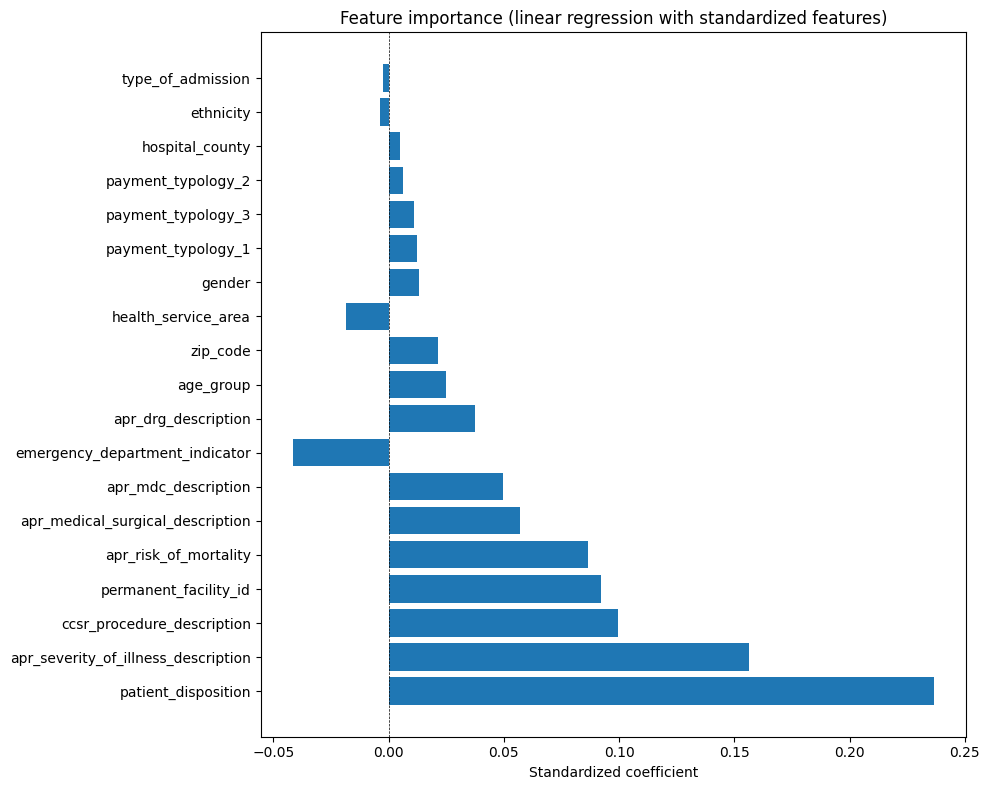

In [15]:
# visualize
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.barh(coef_standardized['feature'], coef_standardized['standardized_coefficient'])
plt.xlabel('Standardized coefficient')
plt.title('Feature importance (linear regression with standardized features)')
plt.axvline(x = 0, color = 'black', linestyle = '--', linewidth = 0.5)
plt.tight_layout()
plt.show()

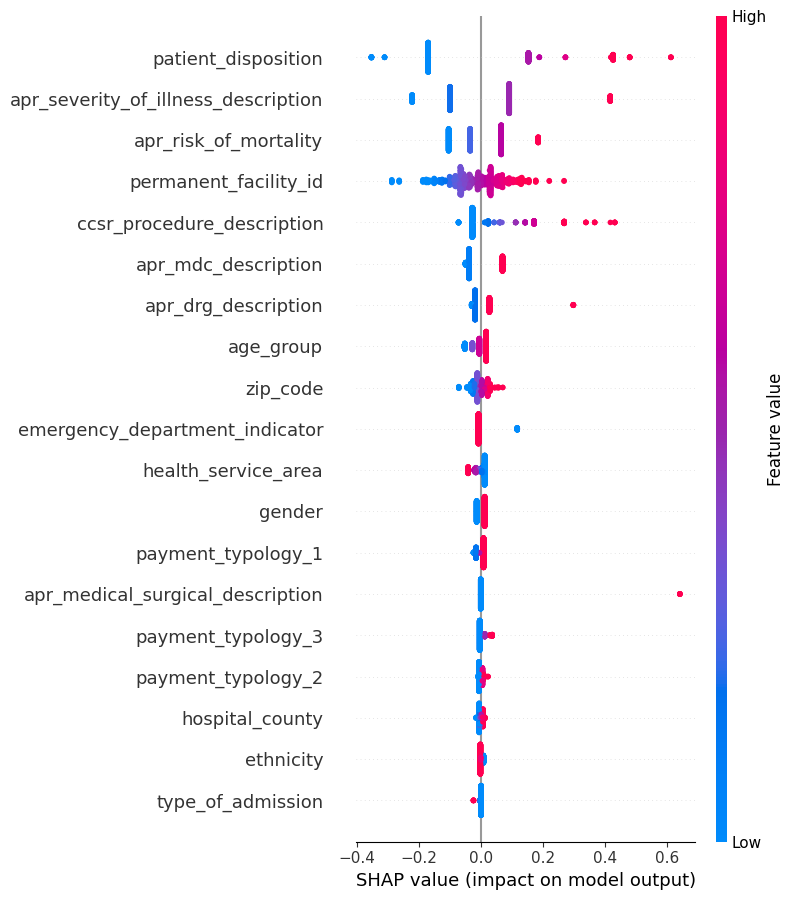

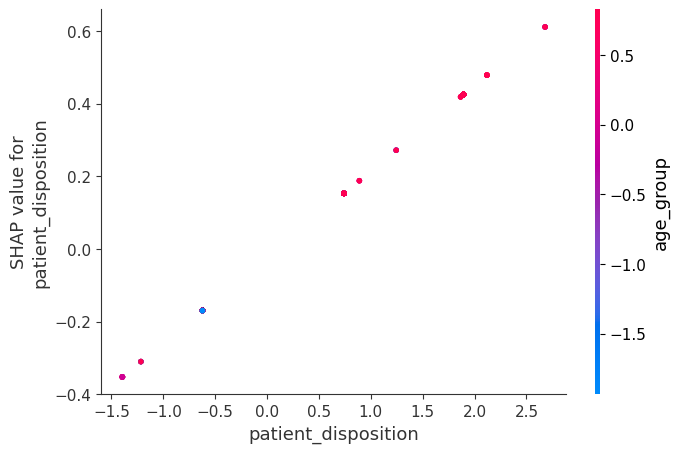

In [16]:
# initialize SHAP explainer for linear regression using standardized features
explainer = shap.Explainer(ols_standardized, X_train_scaled)

# compute SHAP values for validation set
shap_values = explainer(X_val_scaled)

# summary plot: global feature importance
shap.summary_plot(shap_values, X_val_scaled)
shap.dependence_plot("patient_disposition", shap_values.values, X_val_scaled)

In [17]:
shap_importance = pd.DataFrame({
    'feature': X_val_scaled.columns,
    'mean_abs_shap': np.mean(np.abs(shap_values.values), axis = 0)
})

shap_importance = shap_importance.sort_values(by = 'mean_abs_shap', ascending = False).reset_index(drop = True)

print(shap_importance)

                                feature  mean_abs_shap
0                   patient_disposition       0.209392
1   apr_severity_of_illness_description       0.134296
2                 apr_risk_of_mortality       0.075856
3                 permanent_facility_id       0.068472
4            ccsr_procedure_description       0.061723
5                   apr_mdc_description       0.048500
6                   apr_drg_description       0.026172
7                             age_group       0.019777
8                              zip_code       0.015779
9        emergency_department_indicator       0.014648
10                  health_service_area       0.014363
11                               gender       0.012713
12                   payment_typology_1       0.011655
13     apr_medical_surgical_description       0.009323
14                   payment_typology_3       0.006427
15                   payment_typology_2       0.005982
16                      hospital_county       0.004044
17        

Summary of predictors of length of stay (LoS)

Analysis of the OLS model with standardized target-encoded features predicting log(LOS), together with SHAP values, indicates that `patient_disposition` and `apr_severity_of_illness_description` are consistently the strongest predictors across both methods. On the SHAP beeswarm plot, `patient_disposition` also exhibits the greatest horizontal spread, indicating substantial variability in its impact on individual predictions.

Beyond the top two features, rankings differ slightly between the standardized coefficients and SHAP importance:

- `apr_risk_of_mortality` ranks 3rd in SHAP but 5th by coefficient magnitude.
- `permanent_facility_id` is 4th in both.
- `ccsr_procedure_description` is 5th in SHAP vs. 3rd by coefficient.
- `apr_mdc_description` and `apr_drg_description` are closely ranked in both methods.
- `apr_medical_surgical_description` is 6th by coefficient but drops to 14th in SHAP, reflecting minimal impact on individual predictions.

Only the top seven features show notable spread on the beeswarm plot, indicating that the remaining variables have relatively small or consistent effects on predicted LOS. Overall, the findings suggest that patient disposition and severity-of-illness metrics dominate both global and patient-level predictions, while other features play smaller or more context-specific roles.


In [18]:
ols_model = {
    'ols_model': ols_standardized,           # trained OLS
    'encoder': encoder,                      # target encoder
    'category_mappings': category_mappings,  # preprocessing maps
    'scaler': scaler,                        # StandardScaler for features
    'feature_names': retained_features       # column order
}

with open('../models/ols_model.pkl', 'wb') as f:
    pickle.dump(ols_model, f)

Compare the custom target encoded data.

In [19]:
# load the custom target encoded data
with open('../data/temp/custom_target_encoded_data.pkl', 'rb') as f:
    data = pickle.load(f)

X_train = data['X_train']
X_val = data['X_val']
y_train = data['y_train']
y_val = data['y_val']

print(f"Loaded: {data['encoding_method']}")
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")

Loaded: mean_times_median_encoding
X_train: (5769, 20)
X_val: (722, 20)


In [20]:
# fit the model with standardized features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[retained_features])
X_val_scaled = scaler.transform(X_val[retained_features])

# convert back to DataFrame to keep feature names
X_train_scaled = pd.DataFrame(X_train_scaled, columns = retained_features, index = X_train_reduced.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns = retained_features, index = X_val_reduced.index)

# fit OLS on standardized data
ols_standardized = LinearRegression()
ols_standardized.fit(X_train_scaled, y_train)

# predict (log scale)
y_val_pred_log_std = ols_standardized.predict(X_val_scaled)

# evaluate
y_val_pred_std = np.exp(y_val_pred_log_std)
rmse_std = np.sqrt(mean_squared_error(y_val_orig, y_val_pred_std))
mae_std = mean_absolute_error(y_val_orig, y_val_pred_std)
r2_std = r2_score(y_val_orig, y_val_pred_std)

print("\nOLS with standardized custom target encoded features (evaluated on original scale):")
print(f"RMSE: {rmse_std:.3f}, MAE: {mae_std:.3f}, R2: {r2_std:.3f}")


OLS with standardized custom target encoded features (evaluated on original scale):
RMSE: 4.501, MAE: 2.185, R2: 0.472
